# K-means cluster analysis - Assignment Week 4

To do's: This week’s assignment involves running a k-means cluster analysis. Cluster analysis is an unsupervised machine learning method that partitions the observations in a data set into a smaller set of clusters where each observation belongs to only one cluster. The goal of cluster analysis is to group, or cluster, observations into subsets based on their similarity of responses on multiple variables. Clustering variables should be primarily quantitative variables, but binary variables may also be included.

Your assignment is to run a k-means cluster analysis to identify subgroups of observations in your data set that have similar patterns of response on a set of clustering variables.

A k-means cluster analysis performed with the Gapminder dataset was conducted to identify subgroups of countries based on their similarity of responses on 5 variables that represent characteristics that could have an impact on breast cancer incidence. Clustering variables in this case are all quantitative, measuring the consumption of alcohol, CO2 emissions, female employment rate, income per person and life expectancy.
All clustering variables were standardized to have a mean of 0 and a standard deviation of 1. 
Data were not split into training and test set since there is a relatively small number of observations (214 countries).
A series of k-means cluster analyses were conducted on the data specifying k=1-9 clusters, using Euclidean distance. The variance in the clustering variables that was accounted for by the clusters (r-square) was plotted for each of the nine cluster solutions in an elbow curve to provide guidance for choosing the number of clusters to interpret. 

In [34]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

In [35]:
from sklearn import preprocessing
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

## Build model on training data


In [36]:
from sklearn.cluster import KMeans

## Data Management: Loading the GapMinder dataset 

In [37]:
def primary_clean(df, nan_subset = []):
    df = df.rename(columns=lambda x: x.strip()) #remove whitespaces from headers
    #delete all column with just NaN
    df = df.dropna(axis=1, how='all')
    #drop duplicates
    df = df.drop_duplicates()
    #drop compliance = NaN
    df = df.dropna(subset=nan_subset)
    #convert to numeric our objects
    df[nan_subset] = df[nan_subset].apply(pd.to_numeric, errors='coerce')
    return df

In [38]:
df = pd.read_csv('gapminder.csv')

## Set my Variables

In [39]:
#features to be convert to numeric
variables = ['alcconsumption',  'co2emissions', 'femaleemployrate',
              'incomeperperson', 'lifeexpectancy', 'polityscore', 'urbanrate'] #
other = ['breastcancerper100th']

In [40]:
other.extend(variables)
dfgm = primary_clean(df, other)

In [41]:
data_clean = dfgm.dropna()

## Subset clustering variables

In [42]:
dfcluster = data_clean[variables]
dfcluster.describe()

,alcconsumption,co2emissions,femaleemployrate,incomeperperson,lifeexpectancy,polityscore,urbanrate
count,149.000000,1.490000e+02,149.000000,149.000000,149.000000,149.000000,149.000000
mean,6.864698,6.645584e+09,47.995973,6765.439841,68.964758,3.771812,55.544966
std,5.129932,2.966560e+10,14.964263,9890.773248,9.952365,6.273196,22.182150
min,0.050000,2.368667e+06,12.400000,103.775857,47.794000,-10.000000,10.400000
25%,2.560000,8.833733e+07,39.400002,591.067944,62.095000,-2.000000,36.840000
50%,6.080000,3.773037e+08,48.400002,2230.676374,72.640000,6.000000,57.280000
75%,10.080000,2.484926e+09,56.200001,6746.612632,76.126000,9.000000,71.620000
max,23.010000,3.342209e+11,83.300003,39972.352768,83.394000,10.000000,100.000000


In [43]:
cluster_clean = dfcluster.dropna()

In [44]:
scaler = preprocessing.StandardScaler()
cluster_scaled = pd.DataFrame(scaler.fit_transform(cluster_clean), columns=cluster_clean.columns)
cluster_scaled.describe()

,alcconsumption,co2emissions,femaleemployrate,incomeperperson,lifeexpectancy,polityscore,urbanrate
count,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02
mean,-1.490232e-17,2.682418e-17,2.041618e-16,-9.164928e-17,-1.043163e-16,-2.384372e-17,-2.682418e-16
std,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00,1.003373e+00
min,-1.332899e+00,-2.246919e-01,-2.386755e+00,-6.757947e-01,-2.134383e+00,-2.202747e+00,-2.042058e+00
25%,-8.419636e-01,-2.217842e-01,-5.763707e-01,-6.263612e-01,-6.925920e-01,-9.231784e-01,-8.460881e-01
50%,-1.534805e-01,-2.120106e-01,2.709062e-02,-4.600305e-01,3.705287e-01,3.563898e-01,7.848136e-02
75%,6.288867e-01,-1.407250e-01,5.500904e-01,-1.909932e-03,7.219786e-01,8.362279e-01,7.271274e-01
max,3.157889e+00,1.107950e+01,2.367180e+00,3.368686e+00,1.454720e+00,9.961739e-01,2.010850e+00


In [45]:
cluster_scaled.dtypes

alcconsumption      float64
co2emissions        float64
femaleemployrate    float64
incomeperperson     float64
lifeexpectancy      float64
polityscore         float64
urbanrate           float64
dtype: object

# K-means cluster analysis 

In [46]:
clusters = range(1,10)
meandist= []
for k in clusters:
    km = KMeans(n_clusters=k).fit(cluster_scaled)
    clausassign = km.predict(cluster_scaled)
    meandist.append(sum(np.min(cdist(cluster_scaled, km.cluster_centers_, 'minkowski', 2), axis=1))
                    /cluster_scaled.shape[0])

## Plot average distance from observations from the cluster centroid 
## to sue the Elbow Method to identify number of clusters to choose

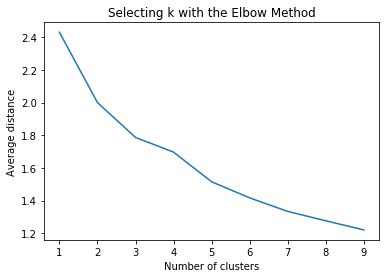

In [47]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

So what this plot shows is the decrease in the average minimum distance of the observations from the cluster centroids for each of the cluster solutions. We can see that the average distance decreases as the number of clusters increases. Since the goal of cluster analysis is to minimize the distance between observations and their assigned clusters we want to chose the fewest numbers of clusters that provides a low average distance. What we’re looking for in this plot is a bend in the elbow that kind of shows where the average distance value might be leveling off such that adding more clusters doesn’t decrease the average distance as much.
We can see there appears to be a couple of bends at the line at two clusters and at three clusters, but it’s not very clear. To help us figure out which of the solutions is best we should further examine the cluster solutions for at least the two and three cluster solutions to see whether they do not overlap, whether the patterns of means on the clustering variables are unique and meaningful, and whether there are significant differences between the clusters on our external validation variable “breastcancerper100th”. 

## Interpret 3 cluster solution

In [79]:
cluster_scale = cluster_scaled.copy()
km3=KMeans(n_clusters=3).fit(cluster_scale)
clusassign=km3.predict(cluster_scale)

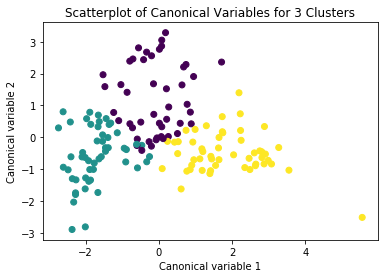

In [80]:
# plot clusters
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(cluster_scale)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=km3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

## Merge cluster assignment with clustering variables

In [50]:
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
cluster_scale.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(cluster_scale['index'])
# create a list of cluster assignments
labels=list(km3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
#newlist

In [51]:
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
len(newclus)

149

In [52]:
# rename the cluster assignment column
newclus.columns = ['cluster']
newclus.head()

,cluster
0,2
1,2
2,1
3,0
4,2


In [53]:
# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe to merge with cluster training data
newclus.reset_index(level=0, inplace=True)

# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(cluster_scale, newclus, on='index')
merged_train.head(n=10)

,index,alcconsumption,co2emissions,femaleemployrate,incomeperperson,lifeexpectancy,polityscore,urbanrate,cluster
0,0,0.083186,-0.217204,-0.395333,-0.492055,0.801826,0.836228,-0.399183,2
1,1,-1.207720,-0.125600,-1.092665,-0.459897,0.420030,-0.283394,0.437634,2
2,2,-0.253232,-0.216372,1.435167,-0.546226,-1.801786,-0.923178,0.052246,1
3,3,0.486105,-0.026161,-0.140538,0.404156,0.699295,0.676282,1.648983,0
4,4,1.329105,-0.223040,-0.925037,-0.551730,0.531938,0.196444,0.376117,2
5,5,0.654314,0.213912,0.442808,1.875171,1.304805,0.996174,1.501522,0
6,6,1.082660,-0.073717,0.114257,2.021556,1.198644,0.996174,0.525387,0
7,7,1.266516,-0.207485,0.550090,-0.448443,0.178875,-1.722908,-0.163969,1
8,8,-0.523149,-0.207726,-1.193242,0.582273,0.614205,-1.722908,1.491571,2
9,9,-1.309428,-0.204520,0.375757,-0.629709,-0.002093,0.196444,-1.284851,1


## Cluster frequencies

In [54]:
merged_train.cluster.value_counts()

1    52
2    49
0    48
Name: cluster, dtype: int64

## END multiple steps to merge cluster assignment with clustering variables to examine cluster variable means by cluster

In [55]:
# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
clustergrp

Clustering variable means by cluster


,index,alcconsumption,co2emissions,femaleemployrate,incomeperperson,lifeexpectancy,polityscore,urbanrate
cluster,,,,,,,,
0,74.895833,0.996273,0.309771,0.065924,0.923397,0.878449,0.786245,0.821364
1,73.903846,-0.407675,-0.147408,0.802048,-0.601916,-1.021926,-0.520237,-0.940869
2,73.224490,-0.543307,-0.147016,-0.915732,-0.265784,0.223971,-0.218110,0.193873


## Validate clusters in training data

In [56]:
# validate clusters by examining cluster differences in breastcanerper100th using ANOVA
# first have to merge breast cancer with clustering variables and cluster assignment data 
bc100_data=dfgm['breastcancerper100th']

In [57]:
# split GPA data into train and test sets
bc100_train, bc100_test = train_test_split(bc100_data, test_size=.3, random_state=42)
bc100_train1=pd.DataFrame(bc100_train)


In [58]:
len(bc100_train1)

149

In [59]:
bc100_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(bc100_train1, merged_train, on='index')
len(merged_train_all)

106

In [60]:
sub = merged_train_all[['breastcancerper100th', 'cluster']].dropna()

In [61]:
sub.cluster.dtype

dtype('int64')

In [62]:
bcmod = smf.ols(formula='breastcancerper100th ~ C(cluster)', data=sub).fit()

In [63]:
bcmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     breastcancerper100th   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                 -0.011
Method:                   Least Squares   F-statistic:                    0.5207
Date:                  Tue, 13 Jun 2017   Prob (F-statistic):              0.596
Time:                          00:41:05   Log-Likelihood:                -396.14
No. Observations:                    87   AIC:                             798.3
Df Residuals:                        84   BIC:                             805.7
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          36.2615      4.586      7.908      0.000      27.143      45.380
C(cluster)[T.1]    -1.8171      6.425     -0.283      0.778     -14.593      10.959
C(cluster)[T.2]     4.1120      6.092      0.675      0.502      -8.002      16.226
==============================================================================
Omnibus:                       12.356   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.163
Skew:                           0.988   Prob(JB):                     0.000841
Kurtosis:                       2.964   Cond. No.                         3.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
print ('means for breast cancer by cluster')
m1= sub.groupby('cluster').mean()
m1

means for breast cancer by cluster


,breastcancerper100th
cluster,
0,36.261538
1,34.444444
2,40.373529


In [69]:
print ('standard deviations for breast cancer by cluster')
m2= sub.groupby('cluster').std()
m2

standard deviations for breast cancer by cluster


,breastcancerper100th
cluster,
0,22.144003
1,21.186849
2,25.815820


In [70]:
mc1 = multi.MultiComparison(sub['breastcancerper100th'], sub['cluster'])
res1 = mc1.tukeyhsd()
res1.summary()

group1,group2,meandiff,lower,upper,reject
0,1,-1.8171,-17.1463,13.5121,False
0,2,4.112,-10.4225,18.6465,False
1,2,5.9291,-8.4521,20.3103,False


## Data Analysis:

Predictors with regression coefficients that do not have a value of zero are included in the selected model. Predictors with regression coefficients equal to zero means that the coefficients for those variables had shrunk to zero after applying the LASSO regression penalty, and were subsequently removed from the model. 

Python console results shows that of the 10 variables, 5 were selected in the final model.
So we can also use the size of the regression coefficients to tell us which predictors are the strongest predictors of breast cancer incidence. For example, urban rate and alcohol consumption had the largest regression coefficients, and were most strongly associated with breast cancer incidence, followed by life expectancy and CO2 emissions.
From the first plot we can see the relative importance of the predictor selected at any step of the selection process, how the regression coefficients changed with the addition of a new predictor at each step, as well as the steps at which each variable entered the model. 
The second plot shows the change in the mean square error for the change in the penalty parameter alpha at each step in the selection process.
